# COMP561 Final Project

### Objective: To develop a new algorithm to solve a question from biology

## Project: Prediction of TF binding based on DNA physical properties

The specific sequence of nucleotides creates subtle variation in the width of each groove and in other structural properties. <- These properties have a significant impact on DNA's affinity for proteins, including TFs.

e.g. A given DNA sequence may be bound by a certain TF if it has the right shape (which depends on the sequence context to which it belongs) <=> it may not be bound in the wrong context.


DNA physical properties can be predicted from the local DNA sequence using tools such as DNA shape: https://academic.oup.com/nar/article/43/D1/D103/2439587

Project 3.1: Prediction of TF binding (based on DNA physical properties)
- Chip-seq can identify a list of DNA regions bound by a given TF
- Combined with a computational scan for the TF's position-weight matrix, this can be used to identify SITES that are OCCUPIED BY THE TF IN THE CELL TYPE AND CONDITIONS WHERE THE EXPERIMENTS were carried out.
- Additionally, we can identify a set of DNA sequences that, based on their sequence, look like they should be bound, but that in reality are not.

Goal of the project: To determine whether the sites that are bound (positive examples) can be distinguished from those that are not bound (negative example) BASED ON PREDICTED STRUCTURAL PROPERTIES OF THE SEQUENCE.

The project involves:
1. Identifying a set of bound and non-bound DNA sequences for a given TF based on existing experimental data
2. Calculating the DNA physical properties of each sequence
3. Training a machine learning classifier to distinguish between bound and unbound sites.

## Task: To Predict TF binding (based on DNA physical properties)
- ChIP-seq can identify a list of DNA regions bound by a given TF (c.f. ~300bp)
- Combined with a computational scan for the TF's position-weight matrix, this can be used to identify SITES that are OCCUPIED BY THE TF IN THE CELL TYPE AND CONDITIONS WHERE THE EXPERIMENTS were carried out.
- Additionally, we can identify a set of DNA sequences that, based on their sequence, look like they should be bound, but that in reality are not.

### Goal of the project:
To determine whether the sites that are bound (positive examples) can be distinguished from those that are not bound (negative example) BASED ON PREDICTED STRUCTURAL PROPERTIES OF THE SEQUENCE.

# 1. Identification of a set of bound and non-bound DNA sequences for a given TF (based on existing experimental data)

Note: GM12878 is a particular type of a cell

In [1]:
#tf = 'UA7'
tf = 'AP2'

In [2]:
# install pyranges as necessary

#import sys
#!{sys.executabletable} -m pip install pyranges

## Task: To Predict TF binding (based on DNA physical properties)
- ChIP-seq can identify a list of DNA regions bound by a given TF (c.f. ~300bp)
- Combined with a computational scan for the TF's position-weight matrix, this can be used to identify SITES that are OCCUPIED BY THE TF IN THE CELL TYPE AND CONDITIONS WHERE THE EXPERIMENTS were carried out.
- Additionally, we can identify a set of DNA sequences that, based on their sequence, look like they should be bound, but that in reality are not.

### Goal of the project:
To determine whether the sites that are bound (positive examples) can be distinguished from those that are not bound (negative example) BASED ON PREDICTED STRUCTURAL PROPERTIES OF THE SEQUENCE.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import pyranges as pr
import time

In [3]:
overall_runtime_start = time.time()

In [4]:
# Create a dataframe from the textfile
file_name = "factorbookMotifPos.txt"
df = pd.read_csv(file_name, usecols=[1,2,3,4,5,6], names=['Chom', 'TFStart', 'TFEnd', 'TFName', 'ScoreBS', 'StrandBS'], header=None, sep='\t')

In [5]:
# Get an overview of the dataframe
print(df.shape)
print(df.head(10))

(2366151, 6)
   Chom  TFStart   TFEnd TFName  ScoreBS StrandBS
0  chr1    10461   10476    UA1     2.02        -
1  chr1    10464   10479    UA1     2.26        +
2  chr1    16245   16260   CTCF     1.97        -
3  chr1    89933   89948    NFY     1.95        -
4  chr1    91265   91280   CTCF     1.40        +
5  chr1    91419   91434   CTCF     2.07        +
6  chr1    91421   91436   CTCF     2.80        -
7  chr1    91431   91446   CTCF     1.95        -
8  chr1   104986  105001   CTCF     2.83        +
9  chr1   138972  138987   CTCF     3.43        -


In [6]:
# List out all the transcription factors (TFs)
df_TFs = df["TFName"].value_counts()
print(df_TFs)
df_TFs.to_csv("TFs.csv")

AP1                   166122
CTCF                  158004
UAK42                 130536
SP1                    83782
ZNF263                 75577
EGR1                   67782
PU1                    64532
CEBPB                  62355
FOXA                   59227
v-Maf                  53345
USF                    52584
E2F4                   48827
EBF1                   43843
NRF1                   43592
E2F1                   37259
UAK20                  34713
v-JUN                  34085
UAK19                  32911
UA3                    32281
GATA1                  32249
NFY                    30727
MYC                    30620
RUNX1                  30180
MAX                    29926
AP2                    28487
UAK25                  28092
YY1                    27772
ETS1                   27724
NFKB1                  27709
HNF4                   26564
                       ...  
NFY-UA2                 2506
UA7                     2470
UAK46                   2275
V_RFX1_02     

C:\Users\Yumika\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [7]:
print("Number of transcription factors:", df_TFs.shape[0])

Number of transcription factors: 133


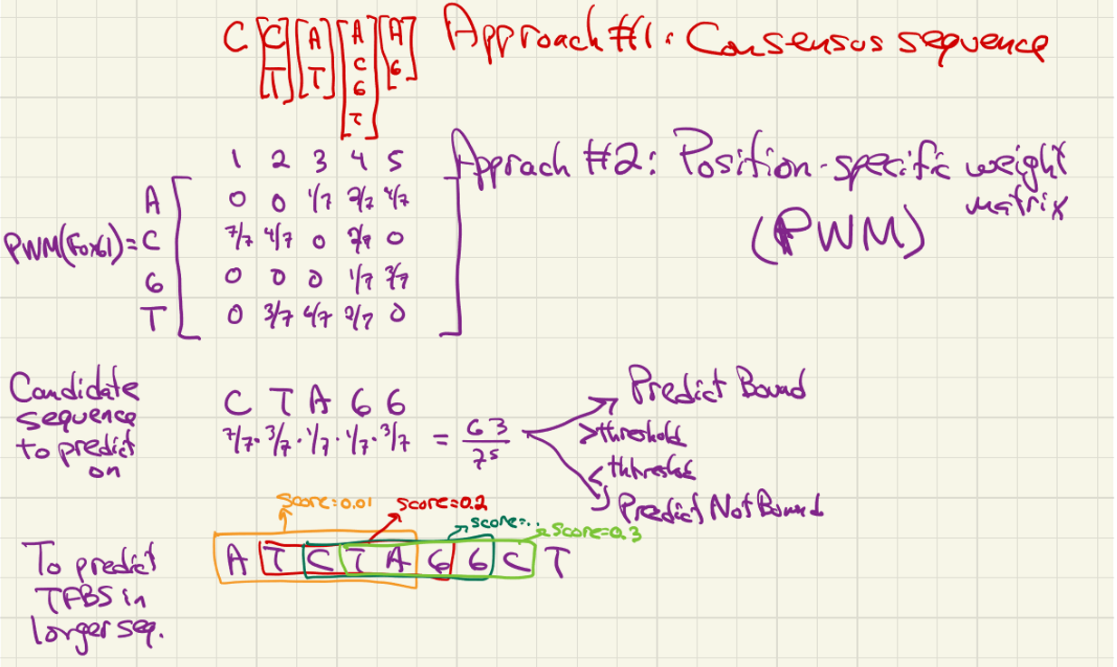

##### Reminder: 
The output of ChIP-seq may contain NONE or MORE THAN 1 TFBS

## ChIP-seq
Input
1. TF of interest
2. Cells

Output
1. Where the TF binds DNA in a particular set of cells

## Motif Discovery
Input
1. A set of sequences, S1,S2,...,Sn, each of length L(=200 e.g.)
2. Each of the sequence is believed to contain more than 1 binding site for the TF of interest
Output
- Consensus sequence for the TF or PWM for TF

## Extract relevant rows: the TF and the + strand
The + and - strands in the bedfile is unknown; therefore, will deal only with + strand first.

In [8]:
# Extract rows containing TBP binding sites information
df_TF = df[df['TFName'] == tf]
df_TF_fwd = df_TF[df_TF['StrandBS'] == '+']
print(df_TF_fwd.shape)
print(df_TF_fwd.head(10))

(14309, 6)
      Chom  TFStart    TFEnd TFName  ScoreBS StrandBS
149   chr1   781168   781183    AP2     0.92        +
510   chr1   876273   876288    AP2     2.01        +
724   chr1   911855   911870    AP2     2.88        +
1143  chr1   957005   957020    AP2     2.54        +
1419  chr1   995087   995102    AP2     1.89        +
1697  chr1  1051469  1051484    AP2     2.24        +
2899  chr1  1279731  1279746    AP2     1.95        +
2900  chr1  1279732  1279747    AP2     2.00        +
2946  chr1  1283411  1283426    AP2     2.07        +
3165  chr1  1310561  1310576    AP2     2.05        +


## Read in the bed file

In [10]:
gr = pr.read_bed("wgEncodeRegTfbsClusteredV3.GM12878.merged.bed")
df_bed = gr.df
print(df_bed.shape)
print("Number of regions:", df_bed.shape[0])
print("\n")
# Show the top and bottom of the bed file
print(df_bed.head(10))
print(df_bed.tail(10))

(78792, 4)
Number of regions: 78792


  Chromosome   Start     End     Name
0       chr1  237550  237989   chr1.1
1       chr1  521310  521756   chr1.2
2       chr1  713702  714675   chr1.3
3       chr1  762022  763345   chr1.4
4       chr1  805100  805473   chr1.5
5       chr1  839802  841023   chr1.6
6       chr1  848092  848620   chr1.7
7       chr1  856280  856826   chr1.8
8       chr1  858297  862058   chr1.9
9       chr1  873457  874094  chr1.10
      Chromosome      Start        End       Name
78782       chrX  154764452  154764876  chrX.2507
78783       chrX  154807318  154807679  chrX.2508
78784       chrX  154841965  154843013  chrX.2509
78785       chrX  154880827  154881309  chrX.2510
78786       chrX  154891942  154892376  chrX.2511
78787       chrX  155049813  155050189  chrX.2512
78788       chrX  155087251  155087687  chrX.2513
78789       chrX  155094268  155094730  chrX.2514
78790       chrX  155110578  155111395  chrX.2515
78791       chrX  155196528  155196958  chrX

### Bedfile: Notes
- Shape: (78792, 4)

In [11]:
list_choms = list(set(df_TF_fwd["Chom"].to_list())) 
print(list_choms)

['chr3', 'chr16', 'chr21', 'chr5', 'chr19', 'chr22', 'chr4', 'chr8', 'chr10', 'chr9', 'chr7', 'chr14', 'chr11', 'chr6', 'chrX', 'chr20', 'chr1', 'chr15', 'chr18', 'chr13', 'chr2', 'chr12', 'chr17']


In [12]:
"""The list was created after inspecting the chromosomes contained in the bed file.
The list of chromosomes were created as below for ordering (sorting the list of chromosomes generated directly from the bed
file dataframe resulted in an undesirable ordering of chromosomes)"""

list_chrs = ['chr%s' % s for s in range(1,23)]
list_chrs.append("chrX")
print(list_chrs)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


### For all chromosomes

In [13]:
## Before the edit on df_TF_negative
start_time_total = time.time()
df_TF_negative_all = pd.DataFrame(columns=['Chom','NStart','NEnd','UnboundTF'])

for chom in list_chrs:
    start_time = time.time()
    print(chom)

    #chom = 'chr7'
    df_bed_chom = df_bed[df_bed["Chromosome"] == chom]
    print(df_bed_chom.head(10))
    df_TF_chom = df_TF_fwd[df_TF_fwd["Chom"] == chom]
    print(df_TF_chom.head(10))
    
    # Sorting to ensure the dataframe is sorted
    df_bed_chom_s = df_bed_chom.sort_values("Start")
    df_TF_chom_s = df_TF_chom.sort_values("TFStart")

    min_bed = df_bed_chom_s["Start"].min()
    max_bed = df_bed_chom_s["End"].max()

    min_TF = df_TF_chom_s["TFStart"].min()
    max_TF = df_TF_chom_s["TFEnd"].max()

    df_bed_non_top = df_bed_chom_s[df_bed_chom_s["End"] < min_TF]  # need to append these
    df_bed_non_top = df_bed_non_top.rename(columns = {"Chromosome":"Chom", "Start":"NStart", "End":"NEnd"})
    # print(df_bed_non_top.head(5))
    if df_bed_non_top.empty == False:
        df_bed_non_top.loc[:, "UnboundTF"] = tf
    df_bed_non_top = df_bed_non_top.drop(["Name"], axis=1)

    df_bed_non_bottom = df_bed_chom_s[df_bed_chom_s["Start"] > max_TF] # need to append these
    df_bed_non_bottom = df_bed_non_bottom.rename(columns = {"Chromosome":"Chom", "Start":"NStart", "End":"NEnd"})
    #print(df_bed_non_bottom)
    if df_bed_non_bottom.empty == False:
        df_bed_non_bottom.loc[:, "UnboundTF"] = tf
    df_bed_non_bottom = df_bed_non_bottom.drop(["Name"], axis=1)
    
    # Extract relevant rows to save computation time
    df_bed_relev = df_bed_chom_s[df_bed_chom_s["Start"] <= max_TF]
    df_bed_relev = df_bed_relev[df_bed_relev["End"] >= min_TF]
    print("dimension of bed_relev", df_bed_relev.shape)
    
    
    list_cols_TF = list(df_TF_chom_s.columns.values)
    df_TF_negative = pd.DataFrame(columns=['Chom','NStart','NEnd','UnboundTF'])

    count = 0
    for index_b, row_b in df_bed_relev.iterrows():
        X = row_b["Start"]
        Y = row_b["End"]

        df_TF_Inregion = pd.DataFrame(columns=list_cols_TF)
        for index_TF, row_TF in df_TF_chom_s.iterrows():
            start = row_TF['TFStart'] 
            end = row_TF['TFEnd']
            if start >= X and Y >= end:
                df_1row = df_TF_chom_s.loc[[index_TF]]
                df_TF_Inregion = df_TF_Inregion.append(df_1row) # ignore_index=True
#             else:
#                 df_1row = df_TF_chom_s.loc[[index_TF]]
#                 df_TF_negative = df_TF_negative.append(df_1row)

        if df_TF_Inregion.empty == False:
            print(count)
            df_TF_Inregion_r = df_TF_Inregion.reset_index()

            beg = X
            ter = Y
            idx_count = df_TF_Inregion_r.shape[0]

            for index_InR, row_InR in df_TF_Inregion_r.iterrows():
                st = row_InR["TFStart"]
                ed = row_InR["TFEnd"]

                if index_InR == 0:  # If it's the first row
                    new_row1 = {'Chom': chom, 'NStart': beg, 'NEnd': st-1, 'UnboundTF': tf}
                    df_TF_negative = df_TF_negative.append(new_row1, ignore_index=True)

                if index_InR == idx_count - 1:
                    new_row2 = {'Chom': chom, 'NStart': ed+1, 'NEnd': ter, 'UnboundTF': tf}
                    df_TF_negative = df_TF_negative.append(new_row2, ignore_index=True)
                    break  # Not absolutely necessary
                else:  # If there are multiple binding sites within a region and if the row is not the last row
                    st_2 = int(df_TF_Inregion_r.loc[[index_InR+1]].TFStart)
                    ed_2 = int(df_TF_Inregion_r.loc[[index_InR+1]].TFEnd)
                    if st_2 > ed: # If the TF binding sites don't overlap
                        new_row = {'Chom': chom, 'NStart': ed+1, 'NEnd': st_2-1, 'UnboundTF': tf}
                        df_TF_negative = df_TF_negative.append(new_row, ignore_index=True)

        count += 1    
    #print(df_TF_negative)
    
    # Create a comprehensive dataframe containing all the negative examples
    all_negative_dfs = [df_bed_non_top, df_TF_negative, df_bed_non_bottom]
    df_negative_all = pd.concat(all_negative_dfs).reset_index(drop=True)
    print(df_negative_all)
    end_time = time.time()
    run_time = end_time - start_time
    print("Running time for {}: {}".format(chom, run_time))  # print("Running time for {0}: {1}".format(chom, run_time))
    
    frames = [df_TF_negative_all, df_negative_all]
    df_TF_negative_all = pd.concat(frames).reset_index(drop=True)
    
    print("====================")

end_time_total = time.time()
run_time_total = end_time_total - start_time_total
print(df_TF_negative_all)
print(df_TF_negative_all.shape)
print("Total running time: ", run_time_total)

chr1
  Chromosome   Start     End     Name
0       chr1  237550  237989   chr1.1
1       chr1  521310  521756   chr1.2
2       chr1  713702  714675   chr1.3
3       chr1  762022  763345   chr1.4
4       chr1  805100  805473   chr1.5
5       chr1  839802  841023   chr1.6
6       chr1  848092  848620   chr1.7
7       chr1  856280  856826   chr1.8
8       chr1  858297  862058   chr1.9
9       chr1  873457  874094  chr1.10
       Chom  TFStart    TFEnd TFName  ScoreBS StrandBS
2774   chr1  1260080  1260101    UA7     0.86        +
2980   chr1  1284764  1284785    UA7     1.32        +
4392   chr1  1711959  1711980    UA7     1.21        +
6112   chr1  2245838  2245859    UA7     2.38        +
7299   chr1  2517947  2517968    UA7     0.94        +
11097  chr1  6052803  6052824    UA7     2.50        +
12198  chr1  6453418  6453439    UA7     1.06        +
12995  chr1  6662844  6662865    UA7     1.31        +
15714  chr1  8483883  8483904    UA7     2.15        +
16092  chr1  8763513  87635

60
120
197
205
242
261
710
803
1356
1406
1433
1435
1477
1496
1507
2170
2732
2791
2992
3396
3512
3688
3738
3746
3835
4065
4679
4731
     Chom     NStart       NEnd UnboundTF
0    chr3      84528      84964       UA7
1    chr3     249642     250011       UA7
2    chr3     254070     254527       UA7
3    chr3     319893     320825       UA7
4    chr3     396036     396415       UA7
5    chr3     418738     419320       UA7
6    chr3     455708     456159       UA7
7    chr3     509833     510257       UA7
8    chr3     523378     523757       UA7
9    chr3     674225     674668       UA7
10   chr3     892734     893160       UA7
11   chr3     893706     894130       UA7
12   chr3     943827     944268       UA7
13   chr3     950493     950917       UA7
14   chr3    1123682    1124115       UA7
15   chr3    1128612    1129057       UA7
16   chr3    1317113    1317556       UA7
17   chr3    1481056    1481487       UA7
18   chr3    2029667    2030091       UA7
19   chr3    5048353    50486

52
116
361
653
879
939
964
1166
1173
1286
1295
1296
1418
1441
1497
1521
1663
1702
1822
1854
1860
2010
2070
2071
2079
2451
2545
2707
2853
2882
2934
2959
3243
3671
3696
3785
4093
4166
     Chom     NStart       NEnd UnboundTF
0    chr6     148248     149088       UA7
1    chr6     157133     157591       UA7
2    chr6     168805     169270       UA7
3    chr6     183657     184081       UA7
4    chr6     188714     190168       UA7
5    chr6     190532     190965       UA7
6    chr6     193671     194323       UA7
7    chr6     209775     210205       UA7
8    chr6     216948     217678       UA7
9    chr6     218034     220327       UA7
10   chr6     224919     228628       UA7
11   chr6     228868     230013       UA7
12   chr6     286566     288045       UA7
13   chr6     289460     289879       UA7
14   chr6     290381     294171       UA7
15   chr6     294493     297144       UA7
16   chr6     303840     304313       UA7
17   chr6     305031     306284       UA7
18   chr6     306606

86
105
392
522
616
776
914
1112
1231
1316
1451
1630
2087
2230
2287
2375
2409
2482
2503
2556
2715
2773
2810
3074
3123
     Chom     NStart       NEnd UnboundTF
0    chr9     214472     216017       UA7
1    chr9     272204     273320       UA7
2    chr9     306939     307372       UA7
3    chr9     316573     316973       UA7
4    chr9     347669     348093       UA7
5    chr9     385788     386163       UA7
6    chr9     459871     460201       UA7
7    chr9     469544     470906       UA7
8    chr9     504128     504913       UA7
9    chr9     546842     547342       UA7
10   chr9     581720     582325       UA7
11   chr9     613696     614244       UA7
12   chr9     757516     757940       UA7
13   chr9     763986     764506       UA7
14   chr9     806569     807212       UA7
15   chr9     882526     882921       UA7
16   chr9     892091     892547       UA7
17   chr9     893744     894375       UA7
18   chr9     910984     911408       UA7
19   chr9     928355     928785       UA7
2

16
277
447
487
561
583
813
1022
1229
1338
1366
1403
1506
1695
1701
1812
1882
2182
2211
2538
2545
2666
2667
2715
2778
2936
2983
3000
3037
3055
3092
3238
3628
3667
3770
3777
3916
3964
      Chom     NStart       NEnd UnboundTF
0    chr12      77398      77779       UA7
1    chr12      83238      83703       UA7
2    chr12      94059      94555       UA7
3    chr12      95189      95673       UA7
4    chr12     175966     176674       UA7
5    chr12     215257     215821       UA7
6    chr12     230836     231166       UA7
7    chr12     262343     262973       UA7
8    chr12     278369     279117       UA7
9    chr12     289638     290099       UA7
10   chr12     298258     298699       UA7
11   chr12     329037     329620       UA7
12   chr12     430733     431165       UA7
13   chr12     497952     499485       UA7
14   chr12     510320     511646       UA7
15   chr12     551446     551813       UA7
16   chr12     562058     562936       UA7
17   chr12     656068     656812       UA7
1

2321
      Chom     NStart       NEnd UnboundTF
0    chr14   20264672   20265133       UA7
1    chr14   20346179   20346611       UA7
2    chr14   20415835   20416217       UA7
3    chr14   20612067   20612495       UA7
4    chr14   20664051   20664481       UA7
5    chr14   20715803   20716229       UA7
6    chr14   20763241   20763667       UA7
7    chr14   20773670   20774462       UA7
8    chr14   20795417   20795841       UA7
9    chr14   20800967   20801766       UA7
10   chr14   20811006   20812134       UA7
11   chr14   20819011   20819447       UA7
12   chr14   20835675   20835879       UA7
13   chr14   20881089   20882078       UA7
14   chr14   20883884   20884509       UA7
15   chr14   20895886   20896608       UA7
16   chr14   20922530   20925836       UA7
17   chr14   20925899   20927198       UA7
18   chr14   20928574   20930990       UA7
19   chr14   20937220   20938677       UA7
20   chr14   20955452   20955954       UA7
21   chr14   20959504   20959939       UA7
22   c

80
128
218
301
303
331
356
363
375
385
413
438
445
449
494
652
1016
1158
1208
1480
1536
1699
1739
1751
1788
1802
1856
1890
2087
2333
2431
2603
2958
2993
3170
3188
3214
3260
3483
3587
3602
3637
3711
      Chom    NStart      NEnd UnboundTF
0    chr17     13260     13812       UA7
1    chr17     14276     14706       UA7
2    chr17     65616     66238       UA7
3    chr17    159079    159716       UA7
4    chr17   1617757   1618096       UA7
5    chr17   1618119   1621453       UA7
6    chr17   2301794   2304437       UA7
7    chr17   2304460   2306110       UA7
8    chr17   4166485   4167336       UA7
9    chr17   4167359   4167811       UA7
10   chr17   5371779   5372394       UA7
11   chr17   5372417   5372662       UA7
12   chr17   5487421   5487888       UA7
13   chr17   5487911   5488340       UA7
14   chr17   6346842   6347544       UA7
15   chr17   6347567   6348075       UA7
16   chr17   6915335   6915838       UA7
17   chr17   6915861   6916268       UA7
18   chr17   6945008   

3375
3378
3382
3384
3455
3456
3466
3537
      Chom    NStart      NEnd UnboundTF
0    chr19    267332    267784       UA7
1    chr19    277562    277920       UA7
2    chr19    281938    282379       UA7
3    chr19    291183    291567       UA7
4    chr19    295163    295783       UA7
5    chr19    495610    495769       UA7
6    chr19    495792    496233       UA7
7    chr19   1102358   1103958       UA7
8    chr19   1103981   1104569       UA7
9    chr19   1104592   1110085       UA7
10   chr19   1406669   1407433       UA7
11   chr19   1407456   1410663       UA7
12   chr19   2060476   2060807       UA7
13   chr19   2060830   2062773       UA7
14   chr19   2739713   2740220       UA7
15   chr19   2740243   2740581       UA7
16   chr19   2819566   2819634       UA7
17   chr19   2819657   2820097       UA7
18   chr19   2900190   2900733       UA7
19   chr19   2900756   2901330       UA7
20   chr19   3721259   3721590       UA7
21   chr19   3721613   3721779       UA7
22   chr19   3989

87
122
130
169
398
585
701
768
1006
1164
1201
1243
1363
      Chom    NStart      NEnd UnboundTF
0    chr22  17255423  17255850       UA7
1    chr22  17264720  17265356       UA7
2    chr22  17372730  17373278       UA7
3    chr22  17392110  17392736       UA7
4    chr22  17398288  17398677       UA7
5    chr22  17413464  17413888       UA7
6    chr22  17490541  17490965       UA7
7    chr22  17517669  17518552       UA7
8    chr22  17539076  17539690       UA7
9    chr22  17555786  17556409       UA7
10   chr22  17565347  17566858       UA7
11   chr22  17576419  17576870       UA7
12   chr22  17587226  17587650       UA7
13   chr22  17600348  17600773       UA7
14   chr22  17601082  17601605       UA7
15   chr22  19466250  19466731       UA7
16   chr22  19466767  19467969       UA7
17   chr22  20004326  20004413       UA7
18   chr22  20004436  20004750       UA7
19   chr22  20103353  20104917       UA7
20   chr22  20104940  20105920       UA7
21   chr22  21103032  21103191       UA7
2

C:\Users\Yumika\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\Yumika\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [28]:
df_TF_negative_fwd = df_TF_negative_all
df_TF_negative_all_fwd = df_TF_negative_all.reindex(columns= ['Chom', 'NStart', 'NEnd','UnboundTF', 'Strand'])
df_TF_negative_all_fwd.loc[:, "Strand"] = "+"
print(df_TF_negative_all_fwd.head(10))
print(df_TF_negative_all_fwd.shape)

   Chom  NStart    NEnd UnboundTF Strand
0  chr1  237550  237989       UA7      +
1  chr1  521310  521756       UA7      +
2  chr1  713702  714675       UA7      +
3  chr1  762022  763345       UA7      +
4  chr1  805100  805473       UA7      +
5  chr1  839802  841023       UA7      +
6  chr1  848092  848620       UA7      +
7  chr1  856280  856826       UA7      +
8  chr1  858297  862058       UA7      +
9  chr1  873457  874094       UA7      +
(4208, 5)


In [29]:
df_all = df_TF_negative_all

In [30]:
# Save the result in a csv file
fname = tf + "_negative_fwd.csv"
df_TF_negative_all_fwd.to_csv(fname, index=False)

In [31]:
# Save the result in a bed file
print(df_TF_negative_all_fwd.head(10))
df_TF_negative_all_fwd = df_TF_negative_all_fwd.drop(["UnboundTF", "Strand"], axis=1)
print(df_TF_negative_all_fwd.head(10))

   Chom  NStart    NEnd UnboundTF Strand
0  chr1  237550  237989       UA7      +
1  chr1  521310  521756       UA7      +
2  chr1  713702  714675       UA7      +
3  chr1  762022  763345       UA7      +
4  chr1  805100  805473       UA7      +
5  chr1  839802  841023       UA7      +
6  chr1  848092  848620       UA7      +
7  chr1  856280  856826       UA7      +
8  chr1  858297  862058       UA7      +
9  chr1  873457  874094       UA7      +
   Chom  NStart    NEnd
0  chr1  237550  237989
1  chr1  521310  521756
2  chr1  713702  714675
3  chr1  762022  763345
4  chr1  805100  805473
5  chr1  839802  841023
6  chr1  848092  848620
7  chr1  856280  856826
8  chr1  858297  862058
9  chr1  873457  874094


In [32]:
foutname = tf + "_fwd_neg.bed"
df_TF_negative_all_fwd.to_csv(foutname, index=False, header=False, sep="\t")

In [33]:
df_TF_negative_all_fwd_chr1 =   df_TF_negative_all_fwd[df_TF_negative_all_fwd['Chom'] == 'chr1']
print(df_TF_negative_all_fwd_chr1.shape)

(226, 3)


In [34]:
gr2 = pr.read_bed(foutname)
df2_bed = gr2.df
print(df2_bed.shape)
print(df2_bed.head(5))

(4208, 3)
  Chromosome   Start     End
0       chr1  237550  237989
1       chr1  521310  521756
2       chr1  713702  714675
3       chr1  762022  763345
4       chr1  805100  805473


# 2. Calculating the DNA physical properties of each sequence
GB Shape: http://rohsdb.cmb.usc.edu/
"Predicted structural properties for every human genome positions are available here"

### Reminder: Goal of the project
To determine whether the sites that are bound (positive examples) can be distinguished from those that are not bound (negative example) BASED ON PREDICTED STRUCTURAL PROPERTIES OF THE SEQUENCE.

### Task 2-1
1. Calculate the DNA physical properties of each sequence
* Using GB shape and the sequences of positive examples and negative examples found in Part 1), get the DNA physical properties of each sequence 

In [21]:
# Create textfiles that can be directly used as input for DNAshape
# Positive examples
df_TF_fwd_m = df_TF_fwd.drop(["TFName", "ScoreBS", "StrandBS"], axis=1)
print(df_TF_fwd_m.head(10))
fout_name = "factorbookMotifPos_GBshape_" + tf
df_TF_fwd_m.to_csv(fout_name + ".txt", sep="\t", index=False, header=False)
df_TF_fwd_m.to_csv(fout_name + ".bed", sep="\t", index=False, header=False)


# Negative 
# df_TF_fwd Chom  TFStart    TFEnd TFName  ScoreBS StrandBS

       Chom  TFStart    TFEnd
2774   chr1  1260080  1260101
2980   chr1  1284764  1284785
4392   chr1  1711959  1711980
6112   chr1  2245838  2245859
7299   chr1  2517947  2517968
11097  chr1  6052803  6052824
12198  chr1  6453418  6453439
12995  chr1  6662844  6662865
15714  chr1  8483883  8483904
16092  chr1  8763513  8763534


In [22]:
overall_runtime_end = time.time()
overall_runtime = overall_runtime_end - overall_runtime_start
print("Overall running time (s):", overall_runtime)

Overall running time (s): 964.6590223312378


### Reminder:
We only need to run DNA shape for bound and unbound DNAs whose locations are identified in part 1.

### Task 2.1:
Extract, from hg19, the actual sequences of bound and unbound sequences.
1. For simplicity, create at least two files: one containing sequences of all 
2. Make sure the format is in a proper fasta format which can be uploaded to DNAshape

In [23]:
# bad_words = '>'
# filein = "temp561.txt"
# fileout = "temp561_seq.txt"

# count = 0
# with open(filein) as fin:
#     with open(fileout, 'w') as fout:
#         for line in fin:
#             if not any(bad_word in line for bad_word in bad_words):
#                 #print(line)
#                 fout.write(line)
#                 count += 1
#         print(count)

### Note:
When I checked whether the outputted sequence (20bp) goes with what the PWM says, none of the sequences violated what PWM said (e.g. 'G' occuring at where Prob(G) = 0).

### Extract bound sequences: Using Galaxy
Workflow
1. For each fasta file of a chromosome (e.g. chr1)
2. Run Galaxy's "Extract Genomic DNA" using the fasta file and "factorbookMotifPos_TBP_fwd_pos.bed" which contains the positions of negative 
3. Download the output
4. Rename the output as, "seqs_chr#_TBP_fwd_pos.fasta" (e.g. seqs_chr1_TBP_fwd_pos.fasta)
5. Repeat for all chromosome

#### Looking at Position Weight Matrix (PWM) of TBP
To confirm that the extracted sequences of positive examples does not violate the PWM of TBP

In [24]:
with open('factorbookMotifPwm.txt') as f:
    for line in f:
        if tf in line:
            line = line.split(",")
            for i in range(len(line)):
                if i == 0:
                    tf_name = line[i].split("\t")[0]
                    tf_len = line[i].split("\t")[1]
                    tf_len = int(tf_len)
                    print("tf_name:", tf_name)
                    print("tf_len:", tf_len)
                    line[i] = line[i].split("\t")[-1]
                else:
                    line[i] = line[i].replace("\t", "")
            del line[-1]
            #tf_name = line[0]
            print(tf_name)
            #print(line)
            print(len(line))
            line_int = [float(i) for i in line]
            # Convert to a numpy array
            pwm_arr = np.array(line_int)
            pwm_arr.astype(int)
            #print(pwm_arr)
            pwm_arr2 = np.reshape(pwm_arr, (4, tf_len))
            print(pwm_arr2)
            print(np.sum(pwm_arr2, axis=0))

tf_name: UA7
tf_len: 21
UA7
84
[[0.174157 0.050562 0.949438 0.988764 0.853933 0.758427 0.022472 0.073034
  0.078652 0.       0.011236 0.646067 0.162921 0.230337 0.157303 0.050562
  0.488764 0.174157 0.235955 0.269663 0.168539]
 [0.264045 0.297753 0.022472 0.005618 0.022472 0.022472 0.808989 0.842697
  0.595506 0.       0.022472 0.207865 0.331461 0.38764  0.11236  0.168539
  0.117978 0.061798 0.185393 0.297753 0.314607]
 [0.511236 0.539326 0.02809  0.       0.123596 0.151685 0.11236  0.078652
  0.005618 0.994382 0.94382  0.123596 0.460674 0.039326 0.651685 0.724719
  0.269663 0.483146 0.264045 0.134831 0.207865]
 [0.050562 0.11236  0.       0.005618 0.       0.067416 0.05618  0.005618
  0.320225 0.005618 0.022472 0.022472 0.044944 0.342697 0.078652 0.05618
  0.123596 0.280899 0.314607 0.297753 0.308989]]
[1.       1.000001 1.       1.       1.000001 1.       1.000001 1.000001
 1.000001 1.       1.       1.       1.       1.       1.       1.
 1.000001 1.       1.       1.       1.      

### Extract unbound sequences: Using Galaxy
Workflow
1. For each fasta file of a chromosome (e.g. chr1)
2. Run Galaxy's "Extract Genomic DNA" using the fasta file and "TBP_fwd_neg.bed" which contains the positions of negative examples
3. Download the output
4. Rename the output as, "seqs_chr#_TBP_fwd_neg.fasta" (e.g. seqs_chr1_TBP_fwd_pos.fasta)
5. Repeat for all chromosome

#### Checklist
            pos, neg
1. chr1
2. chr2
3. chr3
4. chr4
5. chr5
6. chr6
7. chr7
8. chr8
9. chr9
10. chr10
11. chr11
12. chr12
13. chr13
14. chr14
15. chr15
16. chr16
17. chr17
18. chr18
19. chr19
20. chr20
21. chr21
22. chr22
23. chrX

### Using the extracted sequences, calculate the DNA physical properties 
* Use 
DNA properties extracted:
- A


# 3. Training a machine learning classifier to distinguish between bound and unbound sites
GB Shape: http://rohsdb.cmb.usc.edu/
"Predicted structural properties for every human genome positions are available here"

## 3-1. Data-Preprocessing: 
## Mini-objective: Given an input, predict whether the site is bound or unbound

In [25]:
# for elm in chr_nums:
#     fin_name = "./ExtractedSeqs/seqs_TBP_fwd_neg/seqs_chr" + elm + "_TBP_fwd_neg.fasta"
#     fout_name = "./ExtractedSeqs/seqs_TBP_fwd_neg/smaller/seqs_chr" + elm + "_TBP_fwd_neg_smaller.fasta"
    
#     fh = open(fin_name)
#     n = 0
#     for line in fh:
#         if line.startswith(">"):
#             n += 1
#     n = math.ceil(n*0.01)
#     print("n: ", n)
#     fh.close()
    
#     count2 = 0
#     with open(fin_name) as f:
#         with open(fout_name, 'w') as fout:
#             seqs = SeqIO.parse(f, "fasta")
#             samps = ((seq.name, seq.seq) for seq in  sample(list(seqs),n))
#             for samp in samps:
#                 #print(">{}\n{}".format(*samp))
#                 fout.write(">{}\n{}".format(*samp))
#                 fout.write("\n")
#                 count2 += 1
#             print("count2: ", count2)

In [ ]:
import os

directory = r'C:\Users\admin'
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        print(os.path.join(directory, filename))
    else:
        continue